***Добрый день, данная работ принадлежит студенту Яндекс Практикума - Максимовой Анне Дмитриевне, телеграмм аккаунт для связи [Telegram @skorpioshka64](https://t.me/skorpioshka64)***

##### Проект выполнялся в среде `Python` версии `3.12.4`

In [2]:
import os

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns


In [3]:
def preprocessing(df):
    print("Изучение данных датафрейма")
    print("Вывод первых 5 строк \n")
    display(df.head(5))
    print("-" * 100)
    print(f"Размерность датафрейма, составляет - {(df.shape)}")
    print("-" * 100)
    print("Общая информация:\n")
    display(df.info())
    print("-" * 100)
    print("Описательная статистика:\n")
    display(df.describe())
    print("-" * 100)
    df.isna().sum()
    print("Проверка на наличие явных дубликатов:\n")
    display(df.duplicated().sum())
    print("-" * 100)
    print("Вывод количества уникальных значений")
    display(pd.DataFrame(df.apply(lambda x: x.nunique())))

In [6]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    
    '''
    Function optimizes memory usage in dataframe
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''

    # Типы, которые будем проверять на оптимизацию
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1%})'
                        .format(before_size, after_size, (before_size - after_size) / before_size))

    return df

In [5]:
# Пути к файлам
pth1 = "./datasets/base.csv"
pth2 = "./datasets/train.csv"
pth3 = "./datasets/validation.csv"
pth4 = "./datasets/validation_answer.csv"


# Функция для загрузки файлов
def load_csv(filepath):
    if os.path.exists(filepath):
        return pd.read_csv(filepath)
    else:
        print(f"File not found: {filepath}")
        return None


# Загрузка данных
df_base = load_csv(pth1)
df_train = load_csv(pth2)
df_validation = load_csv(pth3)
df_validation_answer = load_csv(pth4)


In [7]:
# стандартизация названий колонок, смена индексации и оптимизации объёма данных
for df in [df_base, df_train, df_validation, df_validation_answer]:
    df.columns = df.columns.str.lower()
    df.set_index("id", inplace=True)
    df = optimize_memory_usage(df)
del df

Размер использования памяти: до 162.52 Mb - после 82.38 Mb (49.3%)
Размер использования памяти: до  5.65 Mb - после  2.90 Mb (48.6%)
Размер использования памяти: до  5.57 Mb - после  2.82 Mb (49.3%)
Размер использования памяти: до  0.15 Mb - после  0.15 Mb (0.0%)


In [13]:
preprocessing(df_base)

Изучение данных датафрейма
Вывод первых 5 строк 



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.311462,157.064423,-4.069252,-340.630859,-57.550140,128.398224,45.090958,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.988342,-1074.464844,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.529083,99.907173,-70.709106,-567.401978,-128.890152,109.914986,201.472198,...,-109.044662,20.916021,-171.201385,-110.596848,67.730103,8.909615,-9.470253,133.295364,-545.897034,-72.913231
1371460-base,-85.565567,-0.493598,-48.374817,-157.985016,96.809509,-81.710213,-22.297688,79.768669,124.357086,105.715179,...,-58.821651,41.369606,-132.934494,-43.016838,67.871925,141.778244,69.048523,111.720383,-1111.038818,-23.087206
3438601-base,-105.564087,15.393871,-46.223934,-158.114883,79.514114,-48.944481,-93.713013,38.581398,123.397957,110.324326,...,-87.907288,-58.806870,-147.794800,-155.830231,68.974754,21.397511,126.098785,139.733200,-1282.707275,-74.527939
422798-base,-74.638878,11.315012,-40.204174,-161.764297,50.507114,-80.775558,-640.923462,65.224998,122.344940,191.465851,...,-30.002094,53.642929,-149.823227,176.921371,69.473282,-43.395180,-58.947716,133.840637,-1074.464844,-1.164146


----------------------------------------------------------------------------------------------------
Размерность датафрейма, составляет - (291813, 72)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       291813 non-null  float32
 1   1       291813 non-null  float32
 2   2       291813 non-null  float32
 3   3       291813 non-null  float32
 4   4       291813 non-null  float32
 5   5       291813 non-null  float32
 6   6       291813 non-null  float32
 7   7       291813 non-null  float32
 8   8       291813 non-null  float32
 9   9       291813 non-null  float32
 10  10      291813 non-null  float32
 11  11      291813 non-null  float32
 12  12      291813 non-null  float32
 13  13      291813 non-null  float32

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,...,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000
mean,-86.274734,8.078087,-44.613483,-146.605530,111.261185,-71.875023,-393.430481,20.391975,123.676727,124.427147,...,-79.075195,33.244843,-154.720276,13.699276,67.792664,23.543148,74.890038,115.611366,-798.355225,-47.701336
std,24.918947,4.949495,38.545929,19.842726,46.350082,28.189743,272.084930,64.297195,6.352832,64.366631,...,30.485073,28.896143,41.217567,98.996414,1.825081,55.353031,61.320347,21.219221,385.414337,41.731026
min,-189.356018,-12.594500,-231.785919,-224.880493,-95.240829,-188.473328,-791.468750,-296.171051,93.684616,-143.499603,...,-214.821136,-85.825500,-346.239319,-157.593872,59.835789,-213.492416,-190.483154,18.601448,-1297.924927,-209.935760
25%,-103.154297,4.709408,-69.535896,-159.882736,80.367638,-91.227936,-631.937866,-22.085905,119.473625,81.685608,...,-98.823830,16.952824,-180.695557,-71.763962,66.582787,-12.501141,33.784821,101.675659,-1074.464844,-75.621109
50%,-86.308128,8.040010,-43.838493,-146.717361,111.776871,-71.751823,-424.306915,20.850153,123.882500,123.456268,...,-78.538177,34.682541,-153.902832,13.167371,67.815048,23.461630,74.876984,116.049271,-1074.464844,-48.403816
75%,-69.254616,11.466815,-19.694052,-133.320145,142.364609,-52.310825,-157.342697,63.989326,127.967766,167.014130,...,-58.638412,52.097710,-127.221359,99.362213,69.028801,59.740337,115.896881,129.625946,-504.291168,-19.684170
max,15.574615,28.751917,151.377075,-55.167892,299.307922,49.880882,109.631989,301.094238,147.870911,402.994598,...,48.822197,141.025269,17.344528,185.096725,75.474625,264.347198,319.601044,213.577255,98.770813,126.973221


----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



11278

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений


,0
0,256118
1,257296
2,257709
3,252056
4,256764
...,...
67,257894
68,257492
69,254869
70,160803


Проверим данные на нормальность с помощью графиков

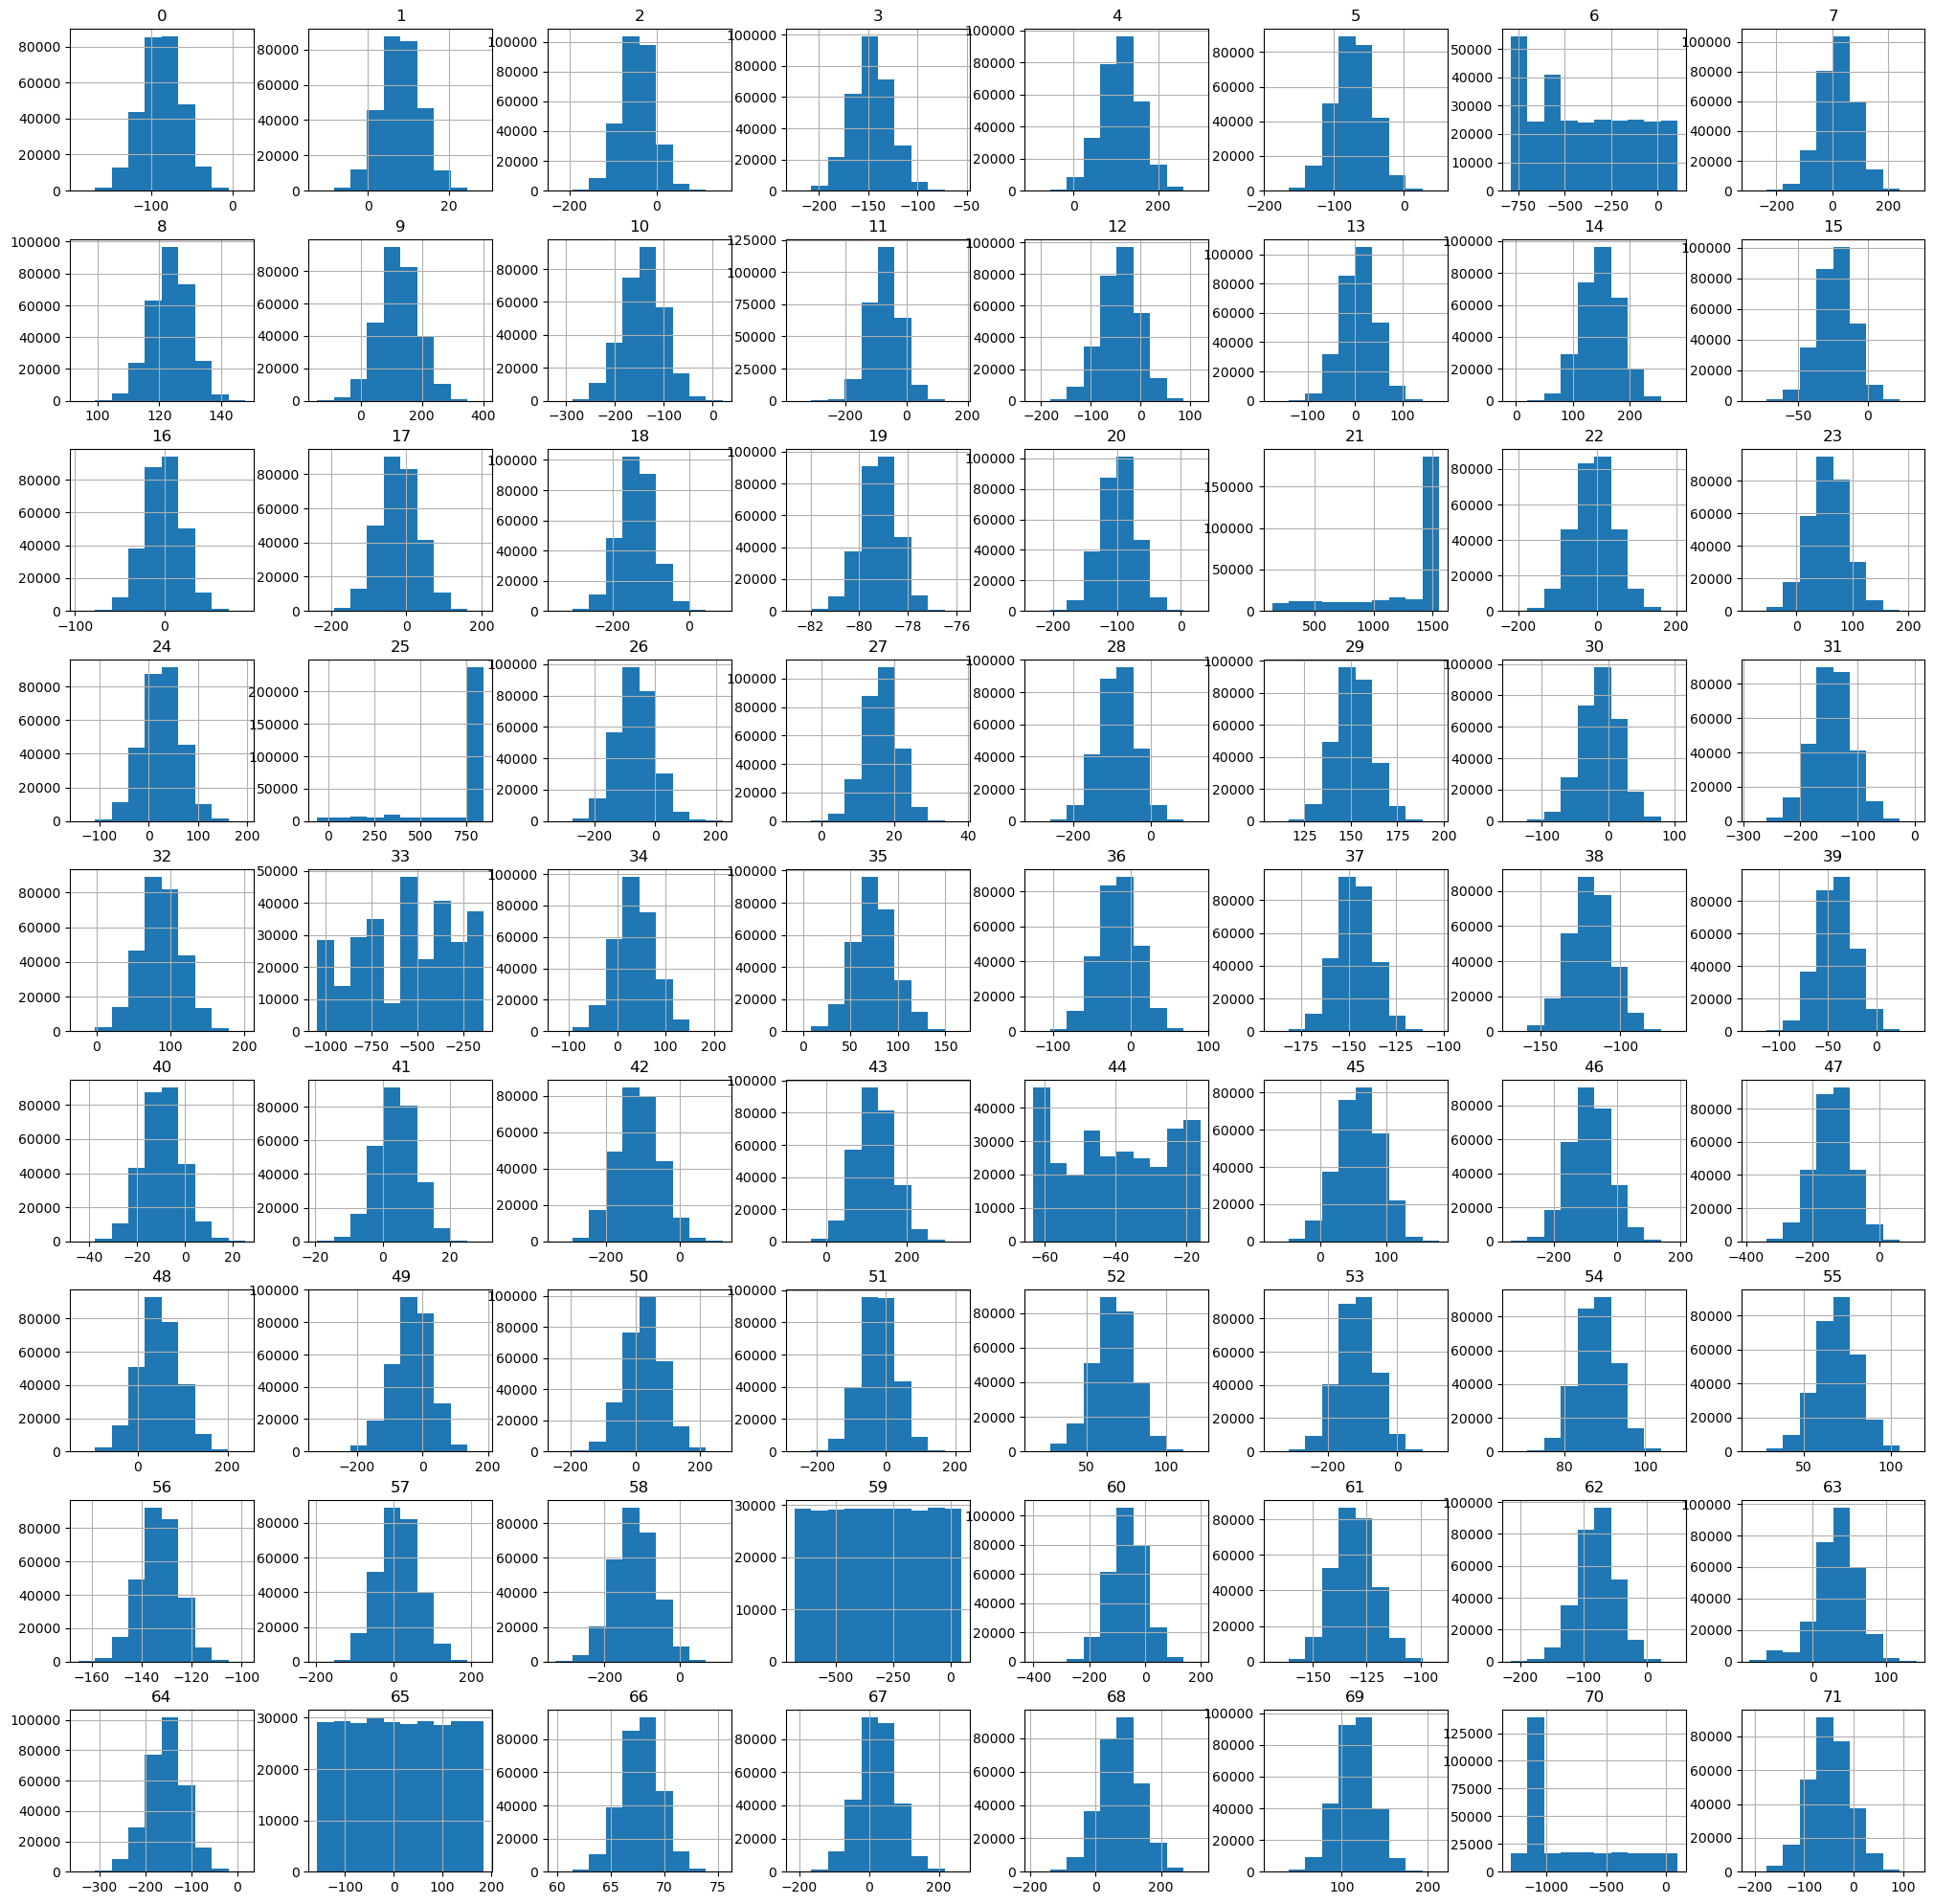

In [9]:
df_base.hist(figsize=(25, 25));

Q-Q график (квантиль-квантиль график): 
Показывает, насколько данные совпадают с нормальным распределением, сравнивая квантиль данных с квантилями нормального распределения.
В Q-Q графике точки должны быть близки к прямой линии, если данные нормально распределены.

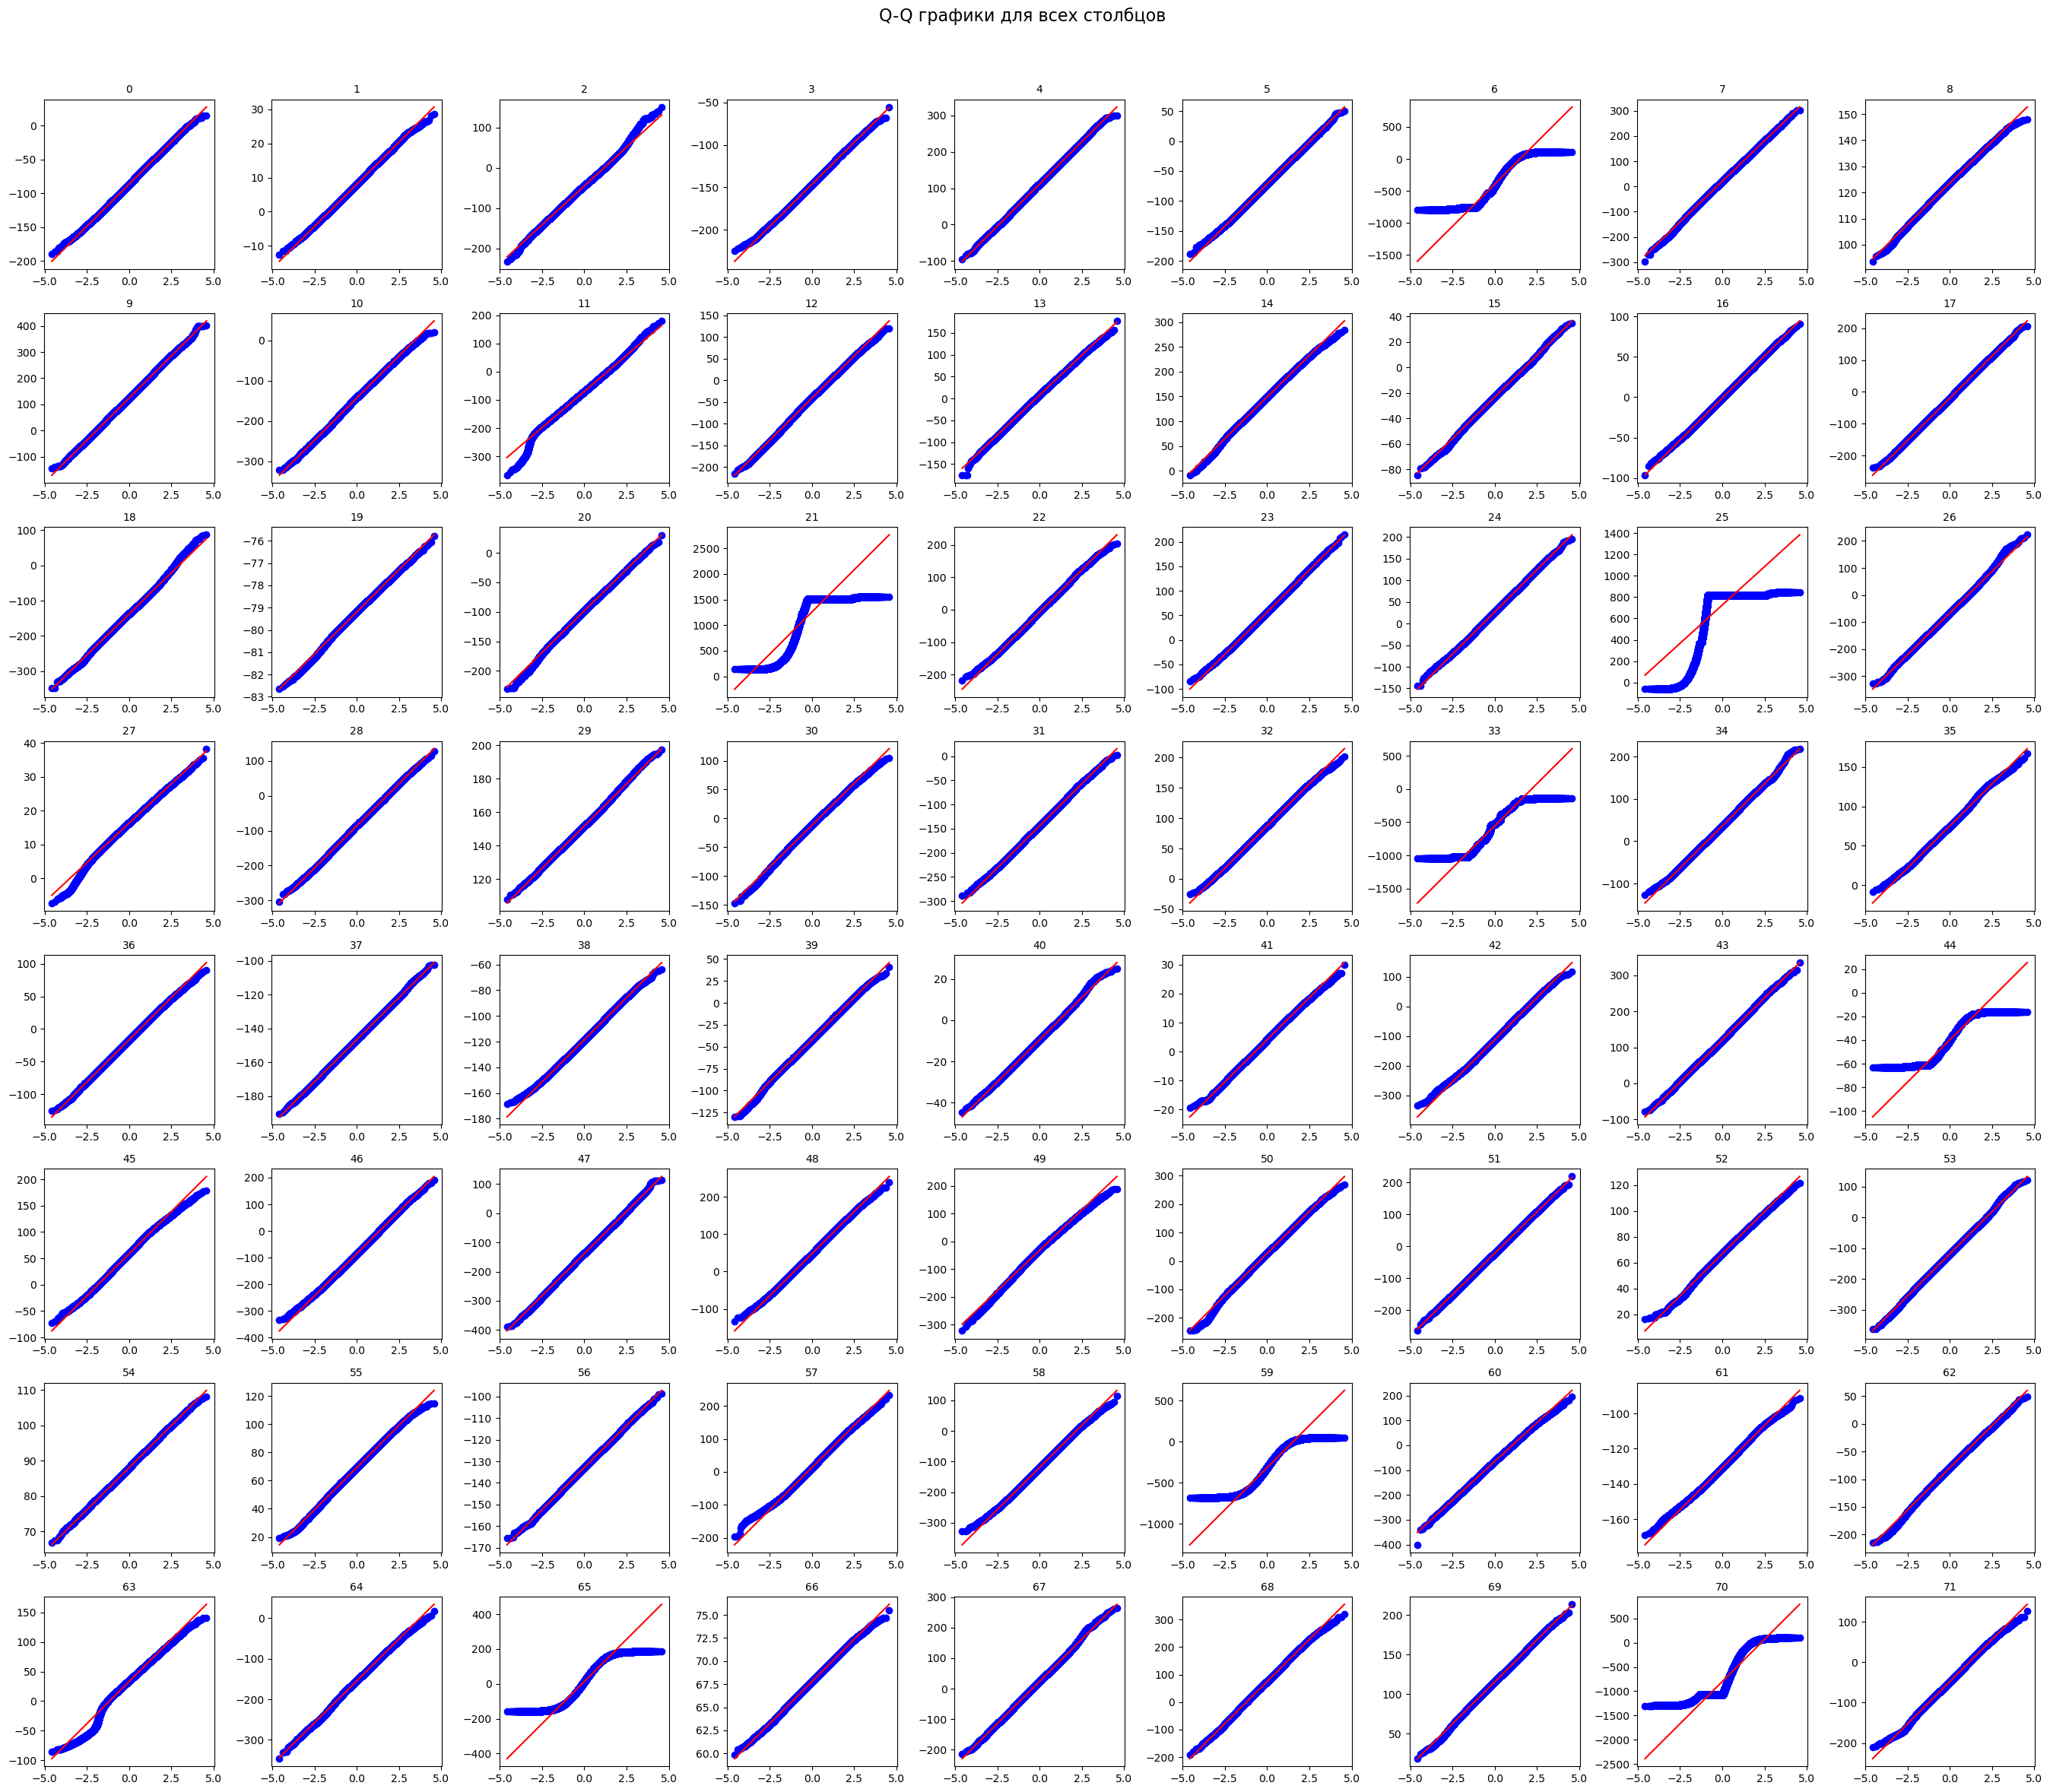

In [10]:
import scipy.stats as stats

# Определение числа строк и столбцов для сетки графиков
rows = 8
cols = 9

# Создание фигуры и осей
fig, axes = plt.subplots(
    rows, cols, figsize=(cols * 3, rows * 3)
)  # Настройка размера фигуры
fig.suptitle("Q-Q графики для всех столбцов", fontsize=16)

# Итерация по столбцам и построение Q-Q графиков
numeric_columns = df_base.select_dtypes(
    include=[np.number]
).columns  # выбор только числовых столбцов

for i, col in enumerate(numeric_columns):
    row = i // cols
    col_pos = i % cols
    ax = axes[row, col_pos]
    stats.probplot(df_base[col], dist="norm", plot=ax)
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Удаление пустых графиков, если количество столбцов не кратно числу графиков в строке
for j in range(len(numeric_columns), rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(
    rect=[0, 0, 1, 0.96]
)  # Подгонка макета и оставление места для основного заголовка
plt.show()


**Вывод**  
В результате анализа датасета с 72 колонками и 291813 строками были получены следующие ключевые моменты:

- Дубликаты: Обнаружено 11278 дубликатов. Рекомендуется провести их удаление для повышения качества анализа и моделирования.
- Пропуски: Пропуски отсутствуют, что позволяет использовать все доступные данные для дальнейшего анализа.
- Типы данных: Все значения числовые и успешно приведены к формату float32, что оптимизирует использование памяти.
- Названия признаков: Признаки без имен, пронумерованные по порядку. Вероятно, данные закодированы, что следует учитывать при интерпретации результатов.
- Стандартизация: Разнообразие диапазонов значений признаков требует стандартизации для улучшения производительности моделей.
- Распределение значений: Большинство признаков имеют распределение, близкое к нормальному. Однако признаки с номерами 6, 21, 25, 33, 44, 59, 65 и 70 имеют отклонения. Рекомендуется рассмотреть возможность их удаления, поскольку недостаток понимания их значимости может усложнить процесс моделирования.